# Skin lesion

## Imports

In [1]:
import os
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf
import PIL.Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

print("TensorFlow version: {}".format(tf.__version__))
print("GPUs available: {}".format(tf.config.list_physical_devices()))
print("The scikit-learn version is {}.".format(sklearn. __version__))

TensorFlow version: 2.4.1
GPUs available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The scikit-learn version is 0.23.2.


## Informações iniciais

In [6]:
import pathlib

labels_path = pathlib.Path(r"ISIC_2019_Training_GroundTruth.csv")

ds = pd.read_csv(labels_path)
ds.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Shape e informações do dataframe

In [4]:
print(ds.shape, end='\n\n')
ds.info()

(25331, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB


### Plot do histograma das classes

In [ ]:
count = {}

for c in ds.columns[1:-2]:
     count[c] = ds[c].value_counts()[1]

count['UNK'] = 0

plt.bar(count.keys(), count.values())
plt.title('histograma das classes')
plt.ylabel('quantidade de itens')
plt.xlabel('classes')
plt.show()

## Preparação dos dados

### Contagem do número de imagens no diretório

In [ ]:
data_dir = pathlib.Path(r"./data")

img_count = len(list(data_dir.glob('*.jpg')))
print(img_count)

In [31]:
# Visualização das imagens no notebook

# import PIL.Image
#
# images = list(data_dir.glob('*.jpg'))
#
# for i in range(10):
#     img = PIL.Image.open(str(images[i]))
#     img.thumbnail((256, 256), PIL.Image.ANTIALIAS)
#     plt.imshow(img)

### Adição da coluna com as classes de lesões

In [ ]:
classes = ds.iloc[:, 1:]

ds = ds.assign(lesion=classes.idxmax(axis=1))
ds.head()

#### Contagem e plot do histograma das classes

In [30]:
# Lesion count
ds['lesion'].value_counts()

NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: lesion, dtype: int64

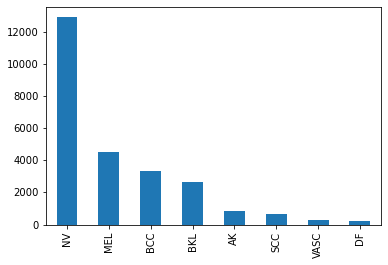

In [29]:
# Plot lesion count as histogram
ds['lesion'].value_counts().plot(kind='bar')

### Inserção dos caminhos para as imagens no dataframe

In [31]:
# Add img path to dataframe
imgs_path = [r"./data/{}.jpg".format(x) for x in list(ds.image)]

ds = ds.assign(image_path=pd.Series(imgs_path).values)

ds.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,image_path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/ISIC_0000000.jpg
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/ISIC_0000001.jpg
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,./data/ISIC_0000002.jpg
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/ISIC_0000003.jpg
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,./data/ISIC_0000004.jpg


### Salva o dataframe pré-processado

In [33]:
# Save dataframe as CSV to avoid preprocessing hassle
#ds.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_processed.csv", index=False)

### Split para treino, validação e teste

In [2]:
df = pd.read_csv(r"isic2019_processed.csv")
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,image_path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/ISIC_0000000.jpg
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/ISIC_0000001.jpg
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,./data/ISIC_0000002.jpg
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/ISIC_0000003.jpg
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,./data/ISIC_0000004.jpg


In [3]:
# Saves truth values to variable 'labels' and the rest of the data to 'x'
labels = df.pop('lesion').to_frame()
x = df

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, labels, stratify=labels, test_size=0.3, random_state=31415)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=1./3, random_state=31415)

In [5]:
print(f"Shape dos dados de treino:    {x_train.shape}, {y_train.shape}")
print(f"Shape dos dados de teste:     {x_test.shape}, {y_test.shape}")
print(f"Shape dos dados de validacao: {x_val.shape}, {y_val.shape}")

Shape dos dados de treino:    (17731, 11), (17731, 1)
Shape dos dados de teste:     (5066, 11), (5066, 1)
Shape dos dados de validacao: (2534, 11), (2534, 1)


In [11]:
# # Rejoin data and truth values
# df_train = pd.concat([x_train, y_train], axis=1)
# df_test = pd.concat([x_test, y_test], axis=1)
# df_val = pd.concat([x_val, y_val], axis=1)
#
# # Save dataframes to disk after previous split
# df_train.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_train.csv", index=False)
# df_test.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_test.csv", index=False)
# df_val.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_val.csv", index=False)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion
18407,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0062259.jpg,NV
597,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0006021_downsampled.jpg,NV
25194,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL
24278,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC
12377,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF


### Pré-processamento
#### *Color Consistency*

Utilizando o método [Shades of Gray (Ingenta Connect)](
https://www.ingentaconnect.com/content/ist/cic/2004/00002004/00000001/art00008?crawler=true) de acordo com o código
disponibilizado [aqui (notebook do Kaggle)](https://www.kaggle.com/apacheco/shades-of-gray-color-constancy)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)

    return img.astype(img_dtype)


##### Antes e depois de aplicar Shades of Gray nas imagens

In [ ]:
# import cv2
# from glob import glob
#
# # Path to images
# img_train_paths = glob("./data/*.jpg")
#
# # Number of images to display
# _n_samples = 8
#
# # Display images before and after Shades of Gray CC
# for path in img_train_paths[0:_n_samples]:
#     _img = cv2.imread(path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
#     img_cc = shade_of_gray_cc (img)
#     _, (ax1,ax2) = plt.subplots(1, 2)
#     ax1.imshow(img)
#     ax2.imshow(img_cc)
#     plt.show()

In [2]:
import os
from tqdm import tqdm

def apply_cc (img_paths, output_folder_path, resize=None):

    if not os.path.isdir(output_folder_path):
        os.mkdir(output_folder_path)

    with tqdm(total=len(img_paths), ascii=True, ncols=100) as t:

        for img_path in img_paths:
            img_name = img_path.split('/')[-1]
            img_ = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if resize is not None:
                img_ = cv2.resize(img_, resize, cv2.INTER_AREA)
            np_img = shade_of_gray_cc (img_)
            cv2.imwrite(os.path.join(output_folder_path, img_name.split('.')[0] + '.jpg'), np_img)
            t.update()


In [4]:
from glob import glob

# Path to images
img_train_paths = glob("./data/*.jpg")

# Apply Shades of Gray to images
apply_cc(img_train_paths, r"./data/shades_cc/")

100%|#########################################################| 25331/25331 [32:33<00:00, 12.97it/s]


### Data augmentation
#### Transformações
* **Conjunto básico** - realiza as seguintes transformações em ordem:
  1. Corte aleatório (*random crop*);
    * A imagem cortada tem de 40 a 100% da área original; e
    * Entre 3/4 a 4/3 das dimensões de largura e comprimento originais.
  2. Transformação *affine*;
    * Rotaciona a imagem em até 90°;
    * Realiza um *shear* de até 20°; e
    * Re-escala a imagem em 80 a 120%.
  3. Inversões (horizontal e vertical) aleatórias (*random flip*);
  4. Modificações aleatórias nas cores, em ordem:
    1. Saturação (entre 70 a 130%);
    2. Contraste (entre 70 a 130%);
    3. Brilho (entre 70 a 130%);
    4. Matiz (entre 90 a 110%);

* **Apagamento aleatório** (*random erasing*) - realiza as operações do conjunto básico mais o apagamento aleatório
  entre o corte e a transformação affine:
  * Preenche até 30% da imagem com ruído;
  * [Código encontrado no GitHub.](https://github.com/yu4u/cutout-random-erasing)

In [32]:
import random

import numpy as np
import skimage as sk
import tensorflow as tf

from skimage import transform, io

# Random crop: 0.4~1.0 of the original area and 3/4~4/3 of the original aspect ratio
def random_crop(image, seed):
    scale = random.uniform(0.8, 1)

    shape = image.shape
    new_width = int(shape[0] * scale)
    new_height = int(shape[1] * scale)

    return tf.image.stateless_random_crop(image, size=(new_width, new_height, shape[2]), seed=seed).numpy()

# Affine: rotate image by 90°, shear by up to 20° and scale area by 0.8~1.2. new pixels are filled symmetrically at edges
def random_affine(image):
    degree = np.deg2rad(random.uniform(0, 90))
    shear_angle = np.deg2rad(random.uniform(0, 20))
    scale = [0.8, 1.2]

    tform = sk.transform.AffineTransform(scale=scale, shear=shear_angle)

    aug = sk.transform.rotate(image, degree)

    return sk.transform.warp(aug, tform)


# Random flips: both horizontally and vertically
def random_flip(image, seed):
    # Randomly flips image horizontally
    aug = tf.image.stateless_random_flip_left_right(image, seed=seed).numpy()

    # Randomly flips image vertically and return
    return tf.image.stateless_random_flip_up_down(aug, seed=seed).numpy()


# Color augmentations: changes saturation, contrast & brightness by random factor from uniform distribution of
# 0.7~1.3, hue is changed by -0.1 to 0.1
def color_augmentations(image, seed):
    aug = tf.image.stateless_random_saturation(image, lower=0.7, upper=1.3, seed=seed).numpy()
    aug = tf.image.stateless_random_contrast(aug, lower=0.7, upper=1.3, seed=seed).numpy()
    aug = tf.image.stateless_random_brightness(aug, max_delta=0.3, seed=seed).numpy()

    return tf.image.stateless_random_hue(aug, max_delta=0.1, seed=seed).numpy()


# Random erasing: fills part of the image (up to 30%) with random noise.
# Source: https://github.com/yu4u/cutout-random-erasing
# Parameters:
# p: probability;
# s_l, s_h: minimum/maximum proportion of erased area against input image;
# r_1, r_2: minimum/maximum aspect ratio of erased area
# v_l, v_h: minimum/maximum value for erased area
# pixel_level: pixel-level randomization for erased area - use True for random noise
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [47]:
# Pipeline for basic set of transformations for data augmentation
def aug_pipeline1(image):
    seed = (int(random.randint(-32768, 32767)), int(random.randint(-32768, 32767)))

    aug = random_crop(image, seed)
    aug = random_affine(aug)
    aug = random_flip(aug, seed)

    return color_augmentations(aug, seed)


# Pipeline for basic set + image erasing
def aug_pipeline2(image):
    seed = (int(random.randint(-32768, 32767)), int(random.randint(-32768, 32767)))
    eraser = get_random_eraser(s_h=0.3, pixel_level=True)

    aug = random_crop(image, seed)
    aug = eraser(aug)
    aug = random_affine(aug)
    aug = random_flip(aug, seed)

    return color_augmentations(aug, seed)


# Method for basic set of data augmentation
def data_aug_set1(row):
    prefix = r"./data/shades_cc/"
    suffix = r"_aug1"
    extens = r".jpg"

    file_path = prefix + row['image'] + suffix + extens
    file_name = row['image'] + suffix

    img = sk.io.imread(row['cc_path'])
    aug = aug_pipeline1(img)
    sk.io.imsave(file_path, aug, quality=100)

    return file_name


# Method containing image erasing set of data augmentation
def data_aug_set2(row):
    prefix = r"./data/shades_cc/"
    suffix = r"_aug2"
    extens = r".jpg"

    file_path = prefix + row['image'] + suffix + extens
    file_name = row['image'] + suffix

    img = sk.io.imread(row['cc_path'])
    aug = aug_pipeline2(img)
    sk.io.imsave(file_path, aug, quality=100)

    return file_name


#### Aplicação do *data augmentation* nas imagens

In [49]:
import pandas as pd

# Open training dataset
train_df = pd.read_csv(r'isic2019_train.csv')
train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion,cc_path
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0062259.jpg,NV,./data/shades_cc/ISIC_0062259.jpg
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0006021_downsampled.jpg,NV,./data/shades_cc/ISIC_0006021_downsampled.jpg
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF,./data/shades_cc/ISIC_0033780.jpg


In [24]:
def cc_path(img_path):
    split = img_path.split('/')

    return split[0] + r'/' + split[1] + r"/shades_cc/" + split[2]


In [25]:
# train_df['cc_path'] = train_df.image_path.apply(lambda row: cc_path(row))
# train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion,cc_path
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0062259.jpg,NV,./data/shades_cc/ISIC_0062259.jpg
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0006021_downsampled.jpg,NV,./data/shades_cc/ISIC_0006021_downsampled.jpg
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF,./data/shades_cc/ISIC_0033780.jpg


In [29]:
# train_df.to_csv(r'isic2019_train.csv', index=False)

In [50]:
# Select images that are not in 'NV' class
aug_df = train_df.loc[train_df['lesion'] != 'NV']
aug_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion,cc_path
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF,./data/shades_cc/ISIC_0033780.jpg
5,ISIC_0065892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0065892.jpg,BKL,./data/shades_cc/ISIC_0065892.jpg
7,ISIC_0068260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0068260.jpg,BCC,./data/shades_cc/ISIC_0068260.jpg


In [51]:
# Count number of items in each class
print(train_df['lesion'].value_counts(), end="\n\n")
print(aug_df['lesion'].value_counts())

NV      9012
MEL     3165
BCC     2326
BKL     1837
AK       607
SCC      440
VASC     177
DF       167
Name: lesion, dtype: int64

MEL     3165
BCC     2326
BKL     1837
AK       607
SCC      440
VASC     177
DF       167
Name: lesion, dtype: int64


##### Conjunto básico de transformações
Corte, *affine*, inversões e alterações nas características das cores.

In [52]:
import random

# Set a seed for RNG
random.seed(31415)

# Apply basic set of augmentations to the original dataset
aug_df['aug_name'] = aug_df.apply(lambda row: data_aug_set1(row), axis=1)

aug_df

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.12536519765853882, 0.4895947277545929]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.027848366647958755, 0.7210644483566284]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.10074776411056519, 0.5379238724708557]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.134646475315094, 0.6951287984848022]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.13503214716911316, 0.5912946462631226]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.042453184723854065, 0.7740158438682556]. Convert image to

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion,cc_path,aug_name
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL,./data/shades_cc/ISIC_0073039.jpg,ISIC_0073039_aug1
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC,./data/shades_cc/ISIC_0071603.jpg,ISIC_0071603_aug1
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF,./data/shades_cc/ISIC_0033780.jpg,ISIC_0033780_aug1
5,ISIC_0065892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0065892.jpg,BKL,./data/shades_cc/ISIC_0065892.jpg,ISIC_0065892_aug1
7,ISIC_0068260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0068260.jpg,BCC,./data/shades_cc/ISIC_0068260.jpg,ISIC_0068260_aug1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17717,ISIC_0033322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0033322.jpg,BKL,./data/shades_cc/ISIC_0033322.jpg,ISIC_0033322_aug1
17720,ISIC_0060995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0060995.jpg,BKL,./data/shades_cc/ISIC_0060995.jpg,ISIC_0060995_aug1
17723,ISIC_0056440,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0056440.jpg,MEL,./data/shades_cc/ISIC_0056440.jpg,ISIC_0056440_aug1
17726,ISIC_0065570,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0065570.jpg,BCC,./data/shades_cc/ISIC_0065570.jpg,ISIC_0065570_aug1


In [53]:
aug_df.drop(columns=['image_path', 'cc_path'], inplace=True)

aug_df.head()

/home/pedro/anaconda3/envs/skinLesion2/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,aug_name
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0073039_aug1
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0071603_aug1
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,ISIC_0033780_aug1
5,ISIC_0065892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0065892_aug1
7,ISIC_0068260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0068260_aug1


In [54]:
# Copy dataframe to select only relevant columns
df_copy = aug_df[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'lesion', 'aug_name']].copy()

# Rename 'aug_name' column to 'image' in order to join with other dataframes
df_copy.rename(columns={"aug_name": "image"}, inplace=True)
df_copy.head()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,image
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0073039_aug1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0071603_aug1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,ISIC_0033780_aug1
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0065892_aug1
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0068260_aug1


In [55]:
train_df.drop(columns=['image_path', 'cc_path'], inplace=True)
train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,cc_path
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/shades_cc/ISIC_0062259.jpg
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/shades_cc/ISIC_0006021_downsampled.jpg
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,./data/shades_cc/ISIC_0033780.jpg


In [57]:
# Join with original training dataframe
joined_df = train_df.append(df_copy, ignore_index=True)
joined_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF
...,...,...,...,...,...,...,...,...,...,...,...
26445,ISIC_0033322_aug1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL
26446,ISIC_0060995_aug1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL
26447,ISIC_0056440_aug1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
26448,ISIC_0065570_aug1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC


In [58]:
# Check if process went well
print("Numero de lesoes no dataframe original:\n", train_df['lesion'].value_counts(), end="\n\n")
print("Numero de lesoes apos data augmentation:\n", joined_df['lesion'].value_counts(), end="\n\n")

Numero de lesoes no dataframe original:
 NV      9012
MEL     3165
BCC     2326
BKL     1837
AK       607
SCC      440
VASC     177
DF       167
Name: lesion, dtype: int64

Numero de lesoes apos data augmentation:
 NV      9012
MEL     6330
BCC     4652
BKL     3674
AK      1214
SCC      880
VASC     354
DF       334
Name: lesion, dtype: int64



In [59]:
joined_df['image_path'] = r"./data/shades_cc/" + joined_df['image'] + r".jpg"
joined_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,image_path
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/shades_cc/ISIC_0062259.jpg
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,./data/shades_cc/ISIC_0006021_downsampled.jpg
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,./data/shades_cc/ISIC_0033780.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
26445,ISIC_0033322_aug1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0033322_aug1.jpg
26446,ISIC_0060995_aug1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0060995_aug1.jpg
26447,ISIC_0056440_aug1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,./data/shades_cc/ISIC_0056440_aug1.jpg
26448,ISIC_0065570_aug1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,./data/shades_cc/ISIC_0065570_aug1.jpg


In [60]:
# Save dataframe with basic set of data augmentation
joined_df.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_train_aug1.csv", index=False)

##### Conjunto de transformações contendo apagamento de imagens
Corte, apagamento (*image erasing*), *affine*, inversões e alterações nas características das cores.

In [62]:
# Sanity check
print(train_df['lesion'].value_counts(), end="\n\n")
print(aug_df['lesion'].value_counts())

NV      9012
MEL     3165
BCC     2326
BKL     1837
AK       607
SCC      440
VASC     177
DF       167
Name: lesion, dtype: int64

MEL     3165
BCC     2326
BKL     1837
AK       607
SCC      440
VASC     177
DF       167
Name: lesion, dtype: int64


In [66]:
aug_df['cc_path'] = r"./data/shades_cc/" + aug_df['image'] + r".jpg"

aug_df.drop(columns='aug_name', inplace=True)

aug_df

<ipython-input-66-b25ad299d9a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_df['image_path'] = r"./data/shades_cc/" + aug_df['image'] + r".jpg"


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,aug_name,image_path
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0073039_aug1,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0071603_aug1,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,ISIC_0033780_aug1,./data/shades_cc/ISIC_0033780.jpg
5,ISIC_0065892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0065892_aug1,./data/shades_cc/ISIC_0065892.jpg
7,ISIC_0068260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0068260_aug1,./data/shades_cc/ISIC_0068260.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17717,ISIC_0033322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0033322_aug1,./data/shades_cc/ISIC_0033322.jpg
17720,ISIC_0060995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0060995_aug1,./data/shades_cc/ISIC_0060995.jpg
17723,ISIC_0056440,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,ISIC_0056440_aug1,./data/shades_cc/ISIC_0056440.jpg
17726,ISIC_0065570,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0065570_aug1,./data/shades_cc/ISIC_0065570.jpg


In [69]:
# Apply image erasing set of augmentations to the original dataset
aug_df['aug_name'] = aug_df.apply(lambda row: data_aug_set2(row), axis=1)

# Check if process went well
aug_df

Lossy conversion from float64 to uint8. Range [0.145156592130661, 1.2597103118896484]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.09154927730560303, 0.577825665473938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.06996449828147888, 1.0229285955429077]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1299843192100525, 1.3579719066619873]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.21231532096862793, 0.5056017637252808]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.09965883195400238, 1.2180825471878052]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03833790868520737, 0.8759739

In [70]:
# Check if process went well
aug_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,cc_path,aug_name
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0073039.jpg,ISIC_0073039_aug2
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,./data/shades_cc/ISIC_0071603.jpg,ISIC_0071603_aug2
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,./data/shades_cc/ISIC_0033780.jpg,ISIC_0033780_aug2
5,ISIC_0065892,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0065892.jpg,ISIC_0065892_aug2
7,ISIC_0068260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,./data/shades_cc/ISIC_0068260.jpg,ISIC_0068260_aug2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17717,ISIC_0033322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0033322.jpg,ISIC_0033322_aug2
17720,ISIC_0060995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,./data/shades_cc/ISIC_0060995.jpg,ISIC_0060995_aug2
17723,ISIC_0056440,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,./data/shades_cc/ISIC_0056440.jpg,ISIC_0056440_aug2
17726,ISIC_0065570,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,./data/shades_cc/ISIC_0065570.jpg,ISIC_0065570_aug2


In [71]:
# Copy dataframe to select only relevant columns
df_copy = aug_df[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'lesion', 'aug_name']].copy()

# Rename 'aug_name' column to 'image' in order to join with other dataframes
df_copy.rename(columns={"aug_name": "image"}, inplace=True)
df_copy.head()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,lesion,image
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0073039_aug2
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0071603_aug2
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,DF,ISIC_0033780_aug2
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL,ISIC_0065892_aug2
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC,ISIC_0068260_aug2


In [72]:
# Join with original training dataframe
joined_df = train_df.append(df_copy, ignore_index=True)
joined_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion,cc_path
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0062259.jpg,NV,./data/shades_cc/ISIC_0062259.jpg
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0006021_downsampled.jpg,NV,./data/shades_cc/ISIC_0006021_downsampled.jpg
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF,./data/shades_cc/ISIC_0033780.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26445,ISIC_0033322_aug2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,BKL,NaN
26446,ISIC_0060995_aug2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,BKL,NaN
26447,ISIC_0056440_aug2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,MEL,NaN
26448,ISIC_0065570_aug2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,BCC,NaN


In [73]:
# Check if process went well
print("Numero de lesoes no dataframe original:\n", train_df['lesion'].value_counts(), end="\n\n")
print("Numero de lesoes apos data augmentation:\n", joined_df['lesion'].value_counts(), end="\n\n")


Numero de lesoes no dataframe original:
 NV      9012
MEL     3165
BCC     2326
BKL     1837
AK       607
SCC      440
VASC     177
DF       167
Name: lesion, dtype: int64

Numero de lesoes apos data augmentation:
 NV      9012
MEL     6330
BCC     4652
BKL     3674
AK      1214
SCC      880
VASC     354
DF       334
Name: lesion, dtype: int64



In [74]:
joined_df.drop(columns=['image_path', 'cc_path'])

# Add image path again
joined_df['image_path'] = r"./data/" + joined_df['image'] + r".jpg"
joined_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,lesion,cc_path
0,ISIC_0062259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0062259.jpg,NV,./data/shades_cc/ISIC_0062259.jpg
1,ISIC_0006021_downsampled,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0006021_downsampled.jpg,NV,./data/shades_cc/ISIC_0006021_downsampled.jpg
2,ISIC_0073039,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0073039.jpg,BKL,./data/shades_cc/ISIC_0073039.jpg
3,ISIC_0071603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0071603.jpg,BCC,./data/shades_cc/ISIC_0071603.jpg
4,ISIC_0033780,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,./data/ISIC_0033780.jpg,DF,./data/shades_cc/ISIC_0033780.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26445,ISIC_0033322_aug2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0033322_aug2.jpg,BKL,NaN
26446,ISIC_0060995_aug2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,./data/ISIC_0060995_aug2.jpg,BKL,NaN
26447,ISIC_0056440_aug2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0056440_aug2.jpg,MEL,NaN
26448,ISIC_0065570_aug2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,./data/ISIC_0065570_aug2.jpg,BCC,NaN


In [75]:
# Save dataframe with image erasing set of data augmentation
joined_df.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_train_aug2.csv", index=False)

##### União dos conjuntos de imagens com *data augmentation*

In [19]:
# Combine both sets of augmented imagens into one dataframe
# augmented_df_set3 = pd.concat([augmented_df_set1, augmented_df_set2]).drop_duplicates().reset_index(drop=True)
# print(augmented_df_set3['lesion'].value_counts())

MEL     9495
NV      9012
BCC     6978
BKL     5511
AK      1821
SCC     1320
VASC     531
DF       501
Name: lesion, dtype: int64


In [20]:
# Save dataframe with both sets of data augmentation
# augmented_df_set3.to_csv(r"/home/pedro/Documents/ProjLesaoPele/isic2019_train_aug_full.csv", index=False)

##### Histograma das classes após *data augmentation*

In [23]:
# print("Dataset contendo imagens com o conjunto básico de transformações:")
# print(augmented_df_set1['lesion'].value_counts(), end="\n\n")
#
# print("Dataset contendo imagens com o conjunto de image erasing:")
# print(augmented_df_set2['lesion'].value_counts(), end="\n\n")
#
# print("Dataset contendo imagens ambos conjuntos de transformações:")
# print(augmented_df_set3['lesion'].value_counts(), end="\n\n")
#
#

Dataset contendo imagens com o conjunto básico de transformações:
NV      9012
MEL     6330
BCC     4652
BKL     3674
AK      1214
SCC      880
VASC     354
DF       334
Name: lesion, dtype: int64

Dataset contendo imagens com o conjunto de image erasing:
NV      9012
MEL     6330
BCC     4652
BKL     3674
AK      1214
SCC      880
VASC     354
DF       334
Name: lesion, dtype: int64

Dataset contendo imagens ambos conjuntos de transformações:
MEL     9495
NV      9012
BCC     6978
BKL     5511
AK      1821
SCC     1320
VASC     531
DF       501
Name: lesion, dtype: int64



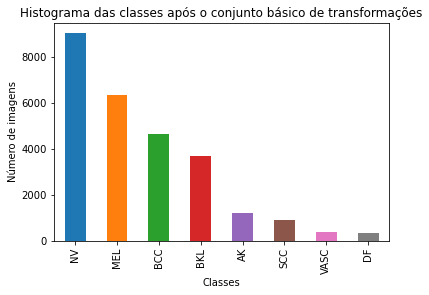

In [36]:
# augmented_df_set1['lesion'].value_counts().plot(kind='bar', xlabel="Classes", ylabel="Número de imagens",
#                                                 color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
#                                                 title="Histograma das classes após o conjunto básico de transformações")
#

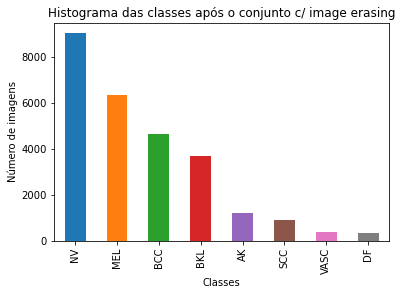

In [37]:
# augmented_df_set2['lesion'].value_counts().plot(kind='bar', xlabel="Classes", ylabel="Número de imagens",
#                                                 color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
#                                                 title="Histograma das classes após o conjunto c/ image erasing")
#

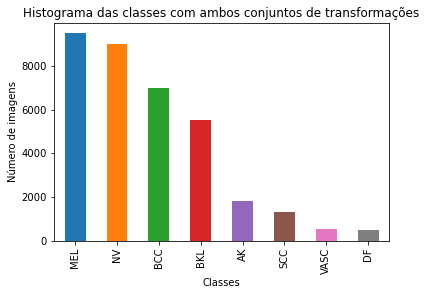

In [38]:
# augmented_df_set3['lesion'].value_counts().plot(kind='bar', xlabel="Classes", ylabel="Número de imagens",
#                                                 color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
#                                                 title="Histograma das classes com ambos conjuntos de transformações")